# AdaBoost

$$
\varepsilon = \displaystyle \sum_{i=1}^N w^{(i)} (\hat{y}^{(i)} \neq y^{(i)})
$$

$$
\alpha = 0.5 \log{\cfrac{1-\varepsilon}{\varepsilon}}
$$

3. トレーニング後、誤分類してしまったデータサンプルの重みを増やす
    - $$\alpha = 0.5 \log{\cfrac{1-\varepsilon}{\varepsilon}}$$ を用いて下式で重みを更新
        - $$\hat{y}^{(i)} = y^{(i)}$$ のとき：$$w^{(i)} \longleftarrow w^{(i)} e^{-\alpha}$$
        - $$\hat{y}^{(i)} \neq y^{(i)}$$ のとき：$$w^{(i)} \longleftarrow w^{(i)} e^{\alpha}$$

In [188]:
import numpy
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

def plot(classifier, data, labels, fig, title=None, xlabel=None, ylabel=None):
    unique_labels = np.unique(labels)
    colors = ['red', 'blue', 'green', 'cyan', 'orange'][:len(unique_labels)]
    x1max, x1min = np.max(data[:, 0]), np.min(data[:, 0])
    x2max, x2min = np.max(data[:, 1]), np.min(data[:, 1])
    scale_x1 = x1max - x1min
    scale_x2 = x2max - x2min
    x1max, x1min = x1max + (x1max-x1min)*0.05, x1min - (x1max-x1min)*0.05
    x2max, x2min = x2max + (x2max-x2min)*0.05, x2min - (x2max-x2min)*0.05
    resolution = scale_x1 / 100
    xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, resolution), np.arange(x2min, x2max, resolution))
    z = np.array([classifier.predict(x) for x in np.array([xx1.ravel(), xx2.ravel()]).T])
    z = z.reshape(xx1.shape)
    if title is not None:
        fig.set_title(title)
    if xlabel is not None:
        fig.set_xlabel(xlabel)
    if ylabel is not None:
        fig.set_ylabel(ylabel)
    fig.contourf(xx1, xx2, z, alpha=0.4, cmap=ListedColormap(colors))
    
    data_of_each_label = {}
    for d, l in zip(data, labels):
        if l in data_of_each_label:
            data_of_each_label[l].append(d)
        else:
            data_of_each_label[l] = [d]
    
    for i in range(len(unique_labels)):
        data = data_of_each_label[unique_labels[i]]
        fig.scatter(np.array(data)[:, 0], np.array(data)[:, 1], s=1, c=colors[i])
    #plt.show()

In [235]:
import numpy as np

class DecisionStump:
    """
    決定株分類器.
    ラベルは1 or -1を想定.

    Attributes
    ----------
    i_f : int
        クラスラベル判別に使う特徴量のインデックス
    th : float
        判別に使う特徴量の閾値
    is_label1_bigger : bool
        閾値以上の場合のクラスラベルが1なら True, -1ならFalse
    r_err : float
        学習済みモデルによる重みつき誤分類率
    """
    
    def __init__(self):
        return
    
    def predict(self, x):
        """
        クラスラベルを判別.
        
        Parameters
        ----------
        x : numpy array (1D)
            判別対象の未知のデータ
        """
        if self.is_label1_bigger:
            return -1 if x[self.i_f]<self.th else 1
        else:
            return 1 if x[self.i_f]<self.th else -1

    def fit(self, data, labels, weight):
        """
        モデルを学習.
        
        Parameters
        ----------
        data : numpy array (2D)
            訓練データサンプル
        labels : numpy array (1D)
            訓練データの正解ラベル
        weight numpy array(1D)
            各訓練データサンプルの重み
        """
        dim = len(data[0])
        n = len(data)
        cost_min = np.inf
        i_f_best = None
        th_best = None
        is_label1_bigger = None
        for i_f in range(dim):
            # i_f 番目の特徴量で並び替え
            j_sorted = np.argsort(data[:, i_f])
            weight_sorted = weight[j_sorted]
            data_sorted = data[j_sorted]
            labels_sorted = labels[j_sorted]
            # コスト（= 重み付き誤分類率）が最小になる閾値を探す
            for i in range(1, n):
                cost1 = np.sum( weight_sorted * (labels_sorted != np.append(np.full(i, 1), np.full(n-i, -1))) )
                cost2 = np.sum( weight_sorted * (labels_sorted != np.append(np.full(i, -1), np.full(n-i, 1))) )
                if cost1 < cost_min or cost2 < cost_min:
                    i_f_best = i_f
                    th_best = (data_sorted[i-1][i_f] + data_sorted[i][i_f]) / 2
                    if cost1 < cost2:
                        cost_min = cost1
                        is_label1_bigger = False
                    else:
                        cost_min = cost2
                        is_label1_bigger = True
        self.i_f = i_f_best
        self.th = th_best
        self.is_label1_bigger = is_label1_bigger
        self.r_err = cost_min


class AdaBoost:
    """
    弱分類器（ここでは決定株）を用いた AdaBoost 分類器.
    ラベルは1 or -1を想定.

    Attributes
    ----------
    n_clf : int
        使用する弱分類器の数
    clf : list[object]
        n_clf 個の学習済み弱分類器
    alpha : list[float]
        誤分類率に基づく各弱分類器の性能
        多数決を取る際の重み付けに用いる
    """
    
    def __init__(self, n_clf):
        self.n_clf = n_clf
    
    def predict(self, x):
        """
        クラスラベルを判別.
        
        Parameters
        ----------
        x : numpy array (1D)
            判別対象の未知のデータ
        """
        return 1 if np.dot(np.array([clf.predict(x) for clf in self.clf]), np.array(self.alpha)) > 0 else -1

    def fit(self, data, labels):
        """
        モデルを学習.
        
        Parameters
        ----------
        data : numpy array (2D)
            訓練データサンプル
        labels : numpy array (1D)
            訓練データの正解ラベル
        """
        self.clf = []
        self.alpha = []
        weight = np.full(len(data), 1.0/len(data))
        for _ in range(self.n_clf):
            # 重み付き決定株をトレーニング
            clf = DecisionStump()
            clf.fit(data, labels, weight)
            self.clf.append(clf)
            # 誤分類したものの重みを増やす
            labels_predict = np.array([clf.predict(d) for d in data])
            a = np.inf if clf.r_err == 0 else 0.5 * np.log((1-clf.r_err)/clf.r_err)
            self.alpha.append(a)
            if clf.r_err == 0:
                break
            for i in range(len(data)):
                if labels_predict[i] == labels[i]:
                    weight[i] *= np.exp(-a)
                else:
                    weight[i] *= np.exp(a)
            # 重みを正規化
            weight /= np.sum(weight)


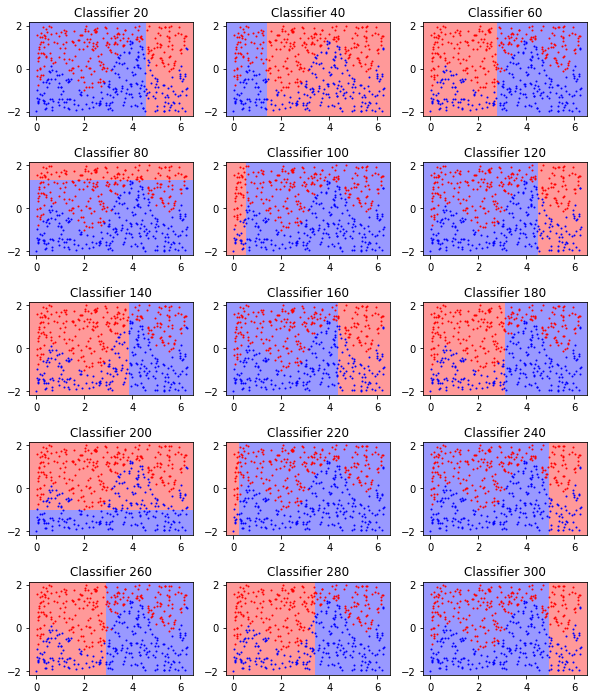

========== result ==========


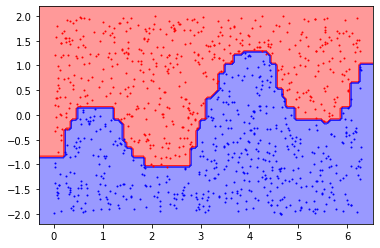

In [242]:
N = 1000
x = np.random.rand(N)*np.pi*2
y = np.random.rand(N)*4-2
data = np.array([x, y]).T
labels = np.array([1 if np.sin(2*d[0])-d[1]>0 else -1 for d in data])
labels = np.array([1 if np.sin(2*d[0])+d[0]/3-1-d[1]>0 else -1 for d in data])

"""
x = np.random.rand(N)
y = np.random.rand(N)
data = np.array([x, y]).T
labels = np.array([1 if d[0]-d[1]>0 else -1 for d in data])
labels = np.array([1 if d[0]<0.6 and d[1]<0.8 else -1 for d in data])
"""

"""
c1 = [0, 0]
c2 = [-3, 4]
r1 = 4*np.random.rand(N//2)
r2 = 3*np.random.rand(N//2)
theta1 = np.random.rand(N//2) * 2 * np.pi
theta2 = np.random.rand(N//2) * 2 * np.pi
data1 = np.array([r1 * np.sin(theta1) + c1[0], r1 * np.cos(theta1) + c1[1]]).T
data2 = np.array([r2 * np.sin(theta2) + c2[0], r2 * np.cos(theta2) + c2[1]]).T
data = np.concatenate([data1, data2])
labels = np.array([1 if i < N//2 else -1 for i in range(N)])
# 外れ値を入れる
for i in range(N//50):
    labels[i] = -1 if labels[i] == 1 else 1
"""

"""
data = np.array([
    [3, 3],
    [-4, -2],
    [4, 2],
    [-3, -3]
])
labels = np.array([1,1,-1,-1])
"""

N_BOOST = 300
ab = AdaBoost(N_BOOST)
ab.fit(data, labels)
#print(ab.alpha)

fig = plt.figure(figsize=(10, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
for i in range(len(ab.clf)):
    if i%20 == 19:
        ax = fig.add_subplot(5, 3, i//20+1)
        clf = ab.clf[i]
        plot(clf, data[::2], labels[::2], ax, title='Classifier {}'.format(i+1))
plt.show()
print('========== result ==========')
plot(ab, data, labels, plt)
plt.show()